# Linear model

This notebook predicts $\Delta$$\tau$ from clinical data following a linear model:

### $\Delta$$\tau$ = $\alpha$$\tau_{BL}$

where $\beta$ is modelled as:

### model 1: $\beta$ = $a$$\sum$$\tau_{BL}$ 
### model 2: $\beta$ = $b$$\sum$$A_{BL}$
### model 3: $\beta$ = $a$$\sum$$\tau_{BL}$ + $b$$\sum$$A_{BL}$ + $c$$\sum$$\tau_{BL}$/$\sum$$A_{BL}$

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## Preprocessing

### Load data from pickle

In [2]:
# Load data from pickle

with open('../data/pickle_data/AD_longitudinal.pkl', 'rb') as handle:
    AD_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/MCI_longitudinal.pkl', 'rb') as handle:
    MCI_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/CN_longitudinal.pkl', 'rb') as handle:
    CN_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/tau.pkl', 'rb') as handle:
    tau = pickle.load(handle)
    
with open('../data/pickle_data/diagnosis.pkl', 'rb') as handle:
    diagnosis = pickle.load(handle)
    
with open('../data/pickle_data/atrophy.pkl', 'rb') as handle:
    atrophy = pickle.load(handle)

with open('../data/pickle_data/mean_cortical_area.pkl', 'rb') as handle:
    mean_cortical_area = pickle.load(handle)
    
AD_MCI_tau_v1 = pd.concat([MCI_longitudinal['tau']['visit_1'], 
                          AD_longitudinal['tau']['visit_1']])
AD_MCI_tau_v3 = pd.concat([MCI_longitudinal['tau']['visit_3'],
                          AD_longitudinal['tau']['visit_3']])

# From previous calculation:
NDM_predicted_regions = ['rh_superiortemporal',
                         'lh_superiortemporal',
                         'rh_lateraloccipital',
                         'lh_lateraloccipital', 
                         'lh_precuneus',
                         'lh_superiorfrontal', 
                         'rh_precuneus', 
                         'rh_superiorfrontal',
                         'rh_bankssts',
                         'lh_pericalcarine',
                         'rh_pericalcarine', 
                         'lh_bankssts']

### Define some useful features
$$FBP = \sum_{n=1}^{n=68} A_\beta $$
$$TBT = \sum_{n=1}^{n=68} \tau_{BL} $$

In [4]:
from cortography.utils import atlas_utils

# Load utility dataframe for DK regions
DK = atlas_utils.load_atlas('DK')

In [5]:
# FBP
fbp = diagnosis['Florbetapir SUVr']
fbp = fbp.loc[AD_MCI_tau_v1.index]

# Sum of tau for cortical areas
cortical_regions = DK[DK['Cortex']=='cortical']['Other Name'].values
total_bl_tau = AD_MCI_tau_v1[cortical_regions].sum(axis=1)

# ratio
ratio = total_bl_tau / fbp

In [6]:
# FBP visual read for AD patients
fbp_visual = diagnosis['FBP Visual Read']
fbp_visual = fbp_visual.loc[AD_MCI_tau_v1.index]
fbp_visual_positive = fbp_visual[fbp_visual == 'Positive']
fbp_visual_negative = fbp_visual[fbp_visual == 'Negative']

#number of fbp patients
print('Number of fbp patients:', fbp_visual.shape[0])
print('Sum of + and -:', fbp_visual_positive.shape[0] + fbp_visual_negative.shape[0])

ad_fbp_visual_positive = list(set.intersection(set(fbp_visual_positive.index), set(AD_longitudinal['tau']['visit_1'].index)))
print('There are', len(ad_fbp_visual_positive), 'AD that are visual + for A-beta')

ad_fbp_visual_negative = set(AD_longitudinal['tau']['visit_1'].index) - set(ad_fbp_visual_positive)
print('There are', len(ad_fbp_visual_negative), 'AD that are visual - for A-beta')

mci_fbp_visual_positive = list(set.intersection(set(fbp_visual_positive.index), set(MCI_longitudinal['tau']['visit_1'].index)))
print('There are', len(mci_fbp_visual_positive), 'MCI that are visual + for A-beta')

mci_fbp_visual_negative = set(MCI_longitudinal['tau']['visit_1'].index) - set(mci_fbp_visual_positive)
print('There are', len(mci_fbp_visual_negative), 'MCI that are visual - for A-beta')


Number of fbp patients: 88
Sum of + and -: 88
There are 18 AD that are visual + for A-beta
There are 10 AD that are visual - for A-beta
There are 28 MCI that are visual + for A-beta
There are 32 MCI that are visual - for A-beta


### Scale data?

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scale_data = False

#min max scaling
if scale_data:
    scaler = StandardScaler()

    total_bl_tau = pd.DataFrame(total_bl_tau)
    total_bl_tau[0] = scaler.fit_transform(pd.DataFrame(total_bl_tau)).ravel()
    total_bl_tau = total_bl_tau[0]

    fbp = pd.DataFrame(fbp)
    fbp[0] = scaler.fit_transform(pd.DataFrame(fbp)).ravel()
    fbp = fbp[0]

    ratio = total_bl_tau / fbp

## Define useful functions

### Cohort selector

The following function makes it easy to select a particular patient cohort from a combination of clinical diagnosis and amyloid status.

In [9]:
def return_subject_ids_for_cohort(clinical_dx, amyloid_status):
    """
    given clinical dx and amyloid status, return a set of indices corresponding to the choice
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both   
    clinical_and_amyloid_set (set): indices of subjects matching request
    """
    ad_patients = set(AD_longitudinal['tau']['visit_1'].index)
    mci_patients = set(MCI_longitudinal['tau']['visit_1'].index)
    ad_mci_patients = ad_patients.union(mci_patients)

    fbp_positive = set(fbp_visual_positive.index)
    fbp_negative = set(fbp_visual_negative.index)
    fbp_positive_negative = fbp_positive.union(fbp_negative)
    
    if clinical_dx == 'AD':
        clinical_dx_set = ad_patients
    elif clinical_dx == 'MCI':
        clinical_dx_set = mci_patients
    elif clinical_dx == 'both':
        clinical_dx_set = ad_mci_patients
        
    if amyloid_status == 'positive':
        amyloid_status_set = fbp_positive
    elif amyloid_status == 'negative':
        amyloid_status_set = fbp_negative
    elif amyloid_status == 'both':
        amyloid_status_set = fbp_positive_negative
        
    clinical_and_amyloid_set = clinical_dx_set.intersection(amyloid_status_set)
    
    return(clinical_and_amyloid_set)

#### Make sure function does what we expect

In [10]:
#test / example:
#return_subject_ids_for_cohort

#assert AD, all amyloid
set_of_all_ADs = set(AD_longitudinal['tau']['visit_1'].index) 
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='both') == set_of_all_ADs)

#assert AD, + amyloid
set_of_all_ADs_fbp_positive = set(AD_longitudinal['tau']['visit_1'].loc[ad_fbp_visual_positive].index)
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='positive') == set_of_all_ADs_fbp_positive)

#assert AD, - amyloid
set_of_all_ADs_fbp_negative = set(AD_longitudinal['tau']['visit_1'].loc[ad_fbp_visual_negative].index)
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='negative') == set_of_all_ADs_fbp_negative)

#assert MCI, all amyloid
set_of_all_MCIs = set(MCI_longitudinal['tau']['visit_1'].index) 
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='both') == set_of_all_MCIs)

#assert MCI, + amyloid
set_of_all_MCIs_fbp_positive = set(MCI_longitudinal['tau']['visit_1'].loc[mci_fbp_visual_positive].index)
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='positive') == set_of_all_MCIs_fbp_positive)

#assert MCI, - amyloid
set_of_all_MCIs_fbp_negative = set(MCI_longitudinal['tau']['visit_1'].loc[mci_fbp_visual_negative].index)
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='negative') == set_of_all_MCIs_fbp_negative)

#assert AD+MCI, all amyloid
set_of_all_subjects = set_of_all_ADs.union(set_of_all_MCIs) 
assert(return_subject_ids_for_cohort(clinical_dx='both', amyloid_status='both') == set_of_all_subjects)

### Get longitudinal data

In [11]:
def get_longitudinal_data(clinical_dx, amyloid_status):
    """
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both            
    
    returns: dictionary with 2 indices: 'baseline' and '18_months' containing tau data.
    """
    try:
        #create subgroups of patients
        subject_IDs = return_subject_ids_for_cohort(clinical_dx=clinical_dx, 
                                                    amyloid_status=amyloid_status)

        AD_v1 = AD_longitudinal['tau']['visit_1']
        AD_v3 = AD_longitudinal['tau']['visit_3']

        MCI_v1 = MCI_longitudinal['tau']['visit_1']
        MCI_v3 = MCI_longitudinal['tau']['visit_3']

        AD_MCI_v1 = pd.concat([AD_v1, MCI_v1])
        AD_MCI_v3 = pd.concat([AD_v3, MCI_v3])    

        subjects_v1 = AD_MCI_v1.loc[subject_IDs]
        subjects_v3 = AD_MCI_v3.loc[subject_IDs]

    except:
        raise TypeError('subject option not recognized')
    
    return({'baseline':subjects_v1, 
            '18_months':subjects_v3})

In [12]:
# test get_longitudinal_data
assert(len(get_longitudinal_data(clinical_dx='AD', amyloid_status='positive')['baseline']) == 18)
assert(len(get_longitudinal_data(clinical_dx='AD', amyloid_status='negative')['baseline']) == 10)

assert(len(get_longitudinal_data(clinical_dx='MCI', amyloid_status='positive')['baseline']) == 28)
assert(len(get_longitudinal_data(clinical_dx='MCI', amyloid_status='negative')['baseline']) == 32)

### Construct model

$$\Delta\tau = (\alpha.\sum_{n=1}^{n=68} \tau + \beta.\sum_{n=1}^{n=68} A_\beta + \gamma.(\sum_{n=1}^{n=68} \tau )/ (\sum_{n=1}^{n=68} A_\beta))\sum_{n=1}^{n=86}\tau_{BL} $$

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2

What the model below does is to create a vector X containing each term in the equation above.
This vector will be fit via linear regression against the measured delta_tau Y and $\alpha \beta \gamma$ will be found.

In [16]:
def make_regression_variables(clinical_dx, amyloid_status, model, 
                              regions_to_average=None,
                              weight_variable_by_region_area=False):
    """
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both            
    model (int):
        0: Δτ = a.τ
        1: Δτ = b.Aβ
        2: Δτ = a.τ + b.Aβ
        3: Δτ = a.τ + b.Aβ + c.(τ / Aβ)
    regions_to_average (list): regions over which X,Y will be averaged over
    strict_AD_selection (bool): If True, only include amyloid + cases in AD cohort
    weight_variable_by_region_area = If True, (cortical) feature will be averaged by region area
    """

    subjects_dictionary = get_longitudinal_data(clinical_dx=clinical_dx, amyloid_status=amyloid_status)
    subjects_v1, subjects_v3 = subjects_dictionary['baseline'], subjects_dictionary['18_months']
    
    X_vec = []
    Y_vec = []
    corticals = list(cortical_regions)
    for p_idx in subjects_v1.index:
#         X0 = np.matmul(L, subjects_v1.loc[p_idx])
        X0 = subjects_v1.loc[p_idx]
        X0 = X0[corticals]
        
        y = subjects_v3.loc[p_idx] - subjects_v1.loc[p_idx]
        y = y[corticals]
        
        # average select group of regions, if desired
        if regions_to_average != None:
            if weight_variable_by_region_area:
                try:
                    #average according to area
                    X0 = (X0*mean_cortical_area[regions_to_average]).sum()
                    X0 = X0/(mean_cortical_area[regions_to_average].sum())

                    y = (y*mean_cortical_area[regions_to_average]).sum()
                    y = y/(mean_cortical_area[regions_to_average].sum())
                except:
                    print("Couldn't get region mean. Is this a subcortical region?")
            else:
                X0 = X0[regions_to_average].mean()
                y = y[regions_to_average].mean()
            
        if model == 0:
            X = np.array([X0*total_bl_tau[p_idx]])
        elif model == 1:
            X = np.array([X0*fbp[p_idx]])
        elif model == 2:
            X = np.array([X0*total_bl_tau[p_idx], X0*fbp[p_idx]])
        elif model == 3:
            X = np.array([X0*total_bl_tau[p_idx], X0*fbp[p_idx], X0*ratio[p_idx]])
        else:
            raise ValueError('model number out of range')
        #reshape X array so regression parameters are together
        if regions_to_average == None:
            for i in range(X.shape[1]):
                X_vec.append([X[j][i] for j in range(len(X))])
        else:
            X_vec.append(X)

        Y_vec.append(y)
        
    X_vec = np.array(X_vec)
    Y_vec = np.array(Y_vec).reshape(-1, 1)
    return({'X':X_vec, 'Y':Y_vec, 'idx':subjects_v1.index})    

In [17]:
#usage:
make_regression_variables(clinical_dx='AD',amyloid_status='positive', model=3, 
                          regions_to_average=None, weight_variable_by_region_area=True)

{'X': array([[ 92.3704    ,   1.888     ,  57.7315    ],
        [ 75.9316    ,   1.552     ,  47.45725   ],
        [ 98.6328    ,   2.016     ,  61.6455    ],
        ...,
        [146.8251    ,   2.422     , 104.87507143],
        [ 77.2317    ,   1.274     ,  55.1655    ],
        [102.6927    ,   1.694     ,  73.35192857]]),
 'Y': array([[ 0.14],
        [ 0.02],
        [ 0.24],
        ...,
        [ 0.11],
        [-0.03],
        [ 0.07]]),
 'idx': Int64Index([ 59968, 944417, 924322, 125928, 470889,  93322, 824747, 771468,
             638383, 128400,  32753, 302547, 381301, 682518, 160855, 757241,
             572507, 265436],
            dtype='int64', name='Randomized ID')}

In [18]:
def select_subset_of_regression_variables(cohort_dict, clinical_dx='both', amyloid_status='both'):
    """ 
    Given a dictionary of regression variables from `make_regression_variables`
    return those matching desired clinical_dx and amyloid_status filter.
    
    Needed for fancy plotting purposes only (subsets are different shape / color)
    """
    ids_of_interest = return_subject_ids_for_cohort(clinical_dx=clinical_dx,
                                                    amyloid_status=amyloid_status)   
    select_cohort = {}
    if 'idx' not in cohort_dict.keys():
        raise NameError('idx key must be included in cohort_dict')

    for key in cohort_dict.keys():
        key_dict = pd.DataFrame(cohort_dict[key]).set_index(cohort_dict['idx'])
        key_dict = key_dict.loc[ids_of_interest]
        if key != 'idk':
            key_dict = np.array(key_dict)
        select_cohort[key] = key_dict
    select_cohort['idx'] = pd.Index(select_cohort['idx'].ravel()) 
    return(select_cohort)

In [19]:
# test select_subset_of_regression_variables function:

#TODO: this only works if regions_to_average == True
regression_dict = make_regression_variables(clinical_dx='both',
                                            amyloid_status='both', 
                                            model=3, 
                                            regions_to_average=list(cortical_regions), 
                                            weight_variable_by_region_area=False)

ad_fbp_positive_idxs_1 = set.intersection(set(fbp_visual_positive.index), set(AD_longitudinal['tau']['visit_1'].index))
ad_fbp_positive_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='positive')['idx']
assert(ad_fbp_positive_idxs_1 == set(ad_fbp_positive_idxs_2))

ad_fbp_negative_idxs_1 = set.intersection(set(fbp_visual_negative.index), set(AD_longitudinal['tau']['visit_1'].index))
ad_fbp_negative_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='negative')['idx']
assert(ad_fbp_negative_idxs_1 == set(ad_fbp_negative_idxs_2))

mci_fbp_positive_idxs_1 = set.intersection(set(fbp_visual_positive.index), set(MCI_longitudinal['tau']['visit_1'].index))
mci_fbp_positive_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='MCI', amyloid_status='positive')['idx']
assert(mci_fbp_positive_idxs_1 == set(mci_fbp_positive_idxs_2))

mci_fbp_negative_idxs_1 = set.intersection(set(fbp_visual_negative.index), set(MCI_longitudinal['tau']['visit_1'].index))
mci_fbp_negative_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='MCI', amyloid_status='negative')['idx']
assert(mci_fbp_negative_idxs_1 == set(mci_fbp_negative_idxs_2))

In [20]:
#example usage
select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='positive')

{'X': array([[ 90.11409412,   1.84188235,  56.32130882],
        [ 66.46871912,   1.27539265,  51.52613885],
        [ 97.39271176,   1.72334118,  67.63382761],
        [ 64.13649412,   1.10714118,  56.26008256],
        [142.59324853,   1.59289706, 129.63022594],
        [120.31180147,   1.82230147,  87.81883319],
        [ 94.91934706,   1.73676176,  64.57098439],
        [ 62.64960147,   1.40138529,  42.91068594],
        [ 69.89299412,   1.57142647,  45.09225427],
        [109.88049412,   1.91947647,  72.76853915],
        [ 94.25887647,   2.07214118,  53.55617981],
        [ 65.9753    ,   1.62525   ,  39.9850303 ],
        [ 69.44762353,   1.5462    ,  45.39060361],
        [ 77.21252353,   1.36395294,  60.32228401],
        [130.96613088,   1.8874    ,  96.29862565],
        [106.97623676,   2.05699412,  65.22941266],
        [150.99660147,   2.38423529,  94.37287592],
        [105.92524853,   1.74732353,  75.66089181]]),
 'Y': array([[ 0.09529412],
        [ 0.02338235],
      

## Run the models

0.18105302670684853
0.2063980982769067
0.21692199303016313
0.2594801414795732


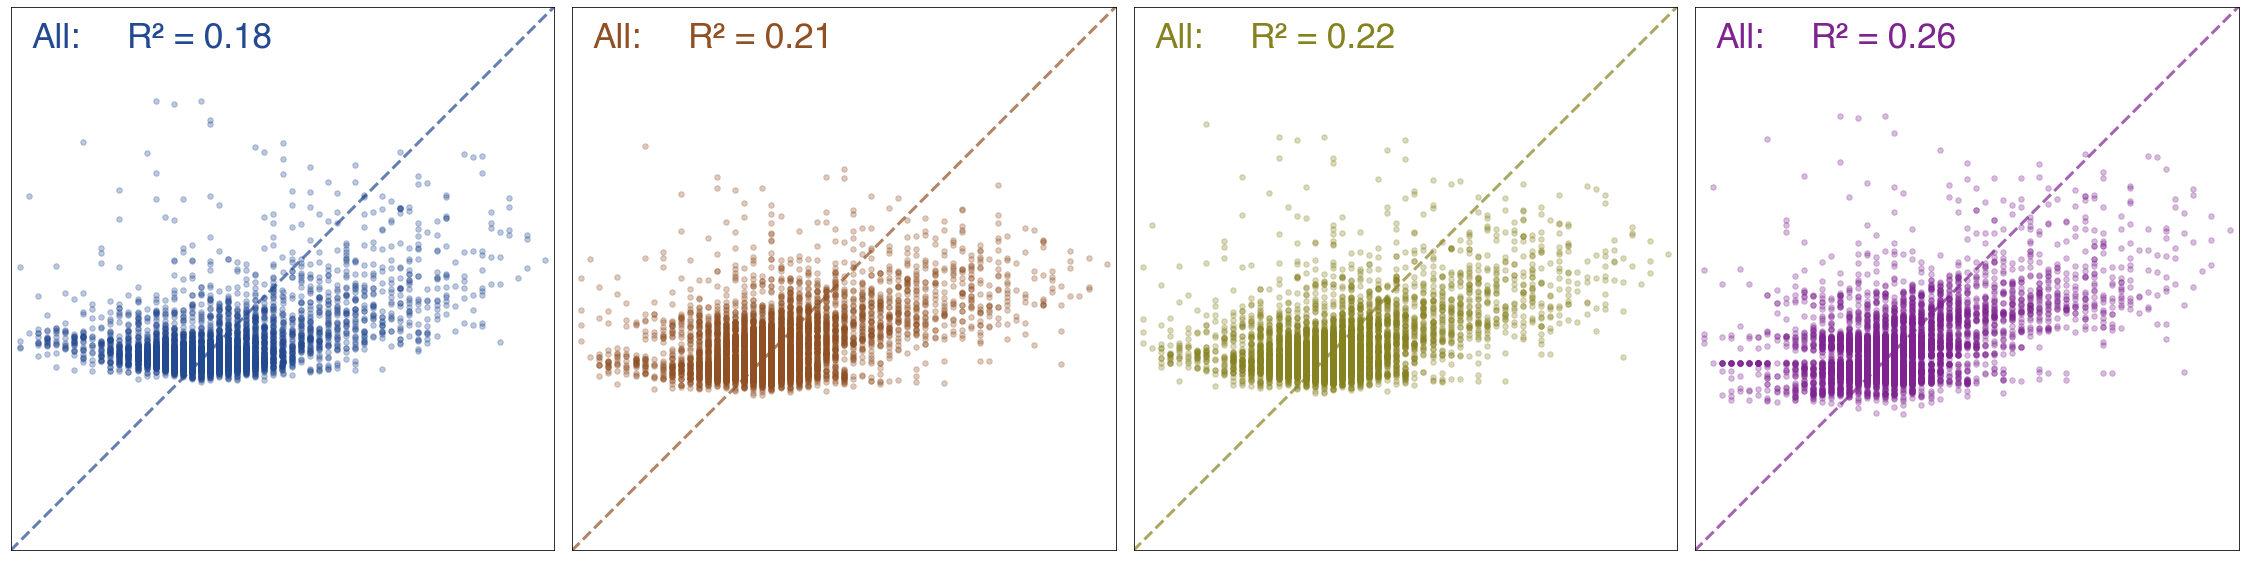

In [64]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
for m in range(4):
    regression_dict = make_regression_variables(clinical_dx='both',
                                        amyloid_status='both', 
                                        model=m, 
                                        regions_to_average=None, 
                                        weight_variable_by_region_area=False)
    
    X,Y = regression_dict['X'], regression_dict['Y']
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X, Y)
    
    score = r2(Y.ravel(), model.predict(X).ravel())
    print(score)

    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
#     plt.xlabel(r'$\Delta\tau_{true}$', fontsize=24)
#     plt.ylabel(r'$\Delta\tau_{predicted}$', fontsize=24)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y.ravel(), model.predict(X).ravel(), color=colors[m], s=30, alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.ylim([-0.2,0.4])
    plt.plot([-0.4,0.4],[-0.4,0.4],'--', color=colors[m],linewidth=3, alpha=0.7)

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.177,0.355, 'All:', fontdict=fontdict)
    plt.text(-0.072,0.355, "R² = "+'{:.2f}'.format(score), fontdict=fontdict)
    
plt.savefig('../results/notebook_figs/M2-all_dx-AD_abeta-all_regions-all_average-n_tick-y.png', 
            dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

## Run bootstrap models

In [22]:
from sklearn.utils import resample

In [23]:
def calculate_bootstrap_samples(X, Y):
    """
    Runs 5000 linear regression models for bootstrapped samples of X and Y.
    Returns a dictionary with X, Y, predictions, models and scores.
    """
    num_repeats = 5000
    bootstrapped_models = []
    bootstrapped_scores = []
    
    for trial in range(num_repeats):
        X_sampled = resample(X, replace=True, n_samples=len(X), random_state=trial)
        Y_sampled = resample(Y, replace=True, n_samples=len(Y), random_state=trial)
        model = LinearRegression().fit(X_sampled, Y_sampled)
        score = r2(Y_sampled.ravel(), model.predict(X_sampled).ravel())

        bootstrapped_models.append(model)
        bootstrapped_scores.append(score)
        
    bootstrapped_preds = []
    for i in range(len(X)):
        x,y = X[i], Y[i]
        y_pred = np.array([model.predict([x]).ravel() for model in bootstrapped_models])
        bootstrapped_preds.append(y_pred)
    bootstrapped_preds = np.array(bootstrapped_preds)
    
    return({'X':X, 'Y':Y, 
            'predictions':bootstrapped_preds, 
            'models':bootstrapped_models,
            'scores':bootstrapped_scores})

### Mean over cortical regions

In [27]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)

    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(cortical_regions), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.20])
            plt.ylim([-0.10,0.20])
            plt.plot([-0.10,0.20],[-0.10,0.20],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.44 ± 0.11
0.48 ± 0.08
0.53 ± 0.09
0.55 ± 0.09
AD both
0.47 ± 0.12
0.53 ± 0.11
0.58 ± 0.11
0.60 ± 0.11
MCI both
0.38 ± 0.20
0.39 ± 0.13
0.46 ± 0.16
0.50 ± 0.16
both positive
0.51 ± 0.11
0.43 ± 0.10
0.54 ± 0.11
0.55 ± 0.11
both negative
0.16 ± 0.14
0.04 ± 0.05
0.20 ± 0.13
0.23 ± 0.13


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.44 $R^2$ = 0.11
$R^2$ = 0.48 $R^2$ = 0.08
$R^2$ = 0.53 $R^2$ = 0.09
$R^2$ = 0.55 $R^2$ = 0.09


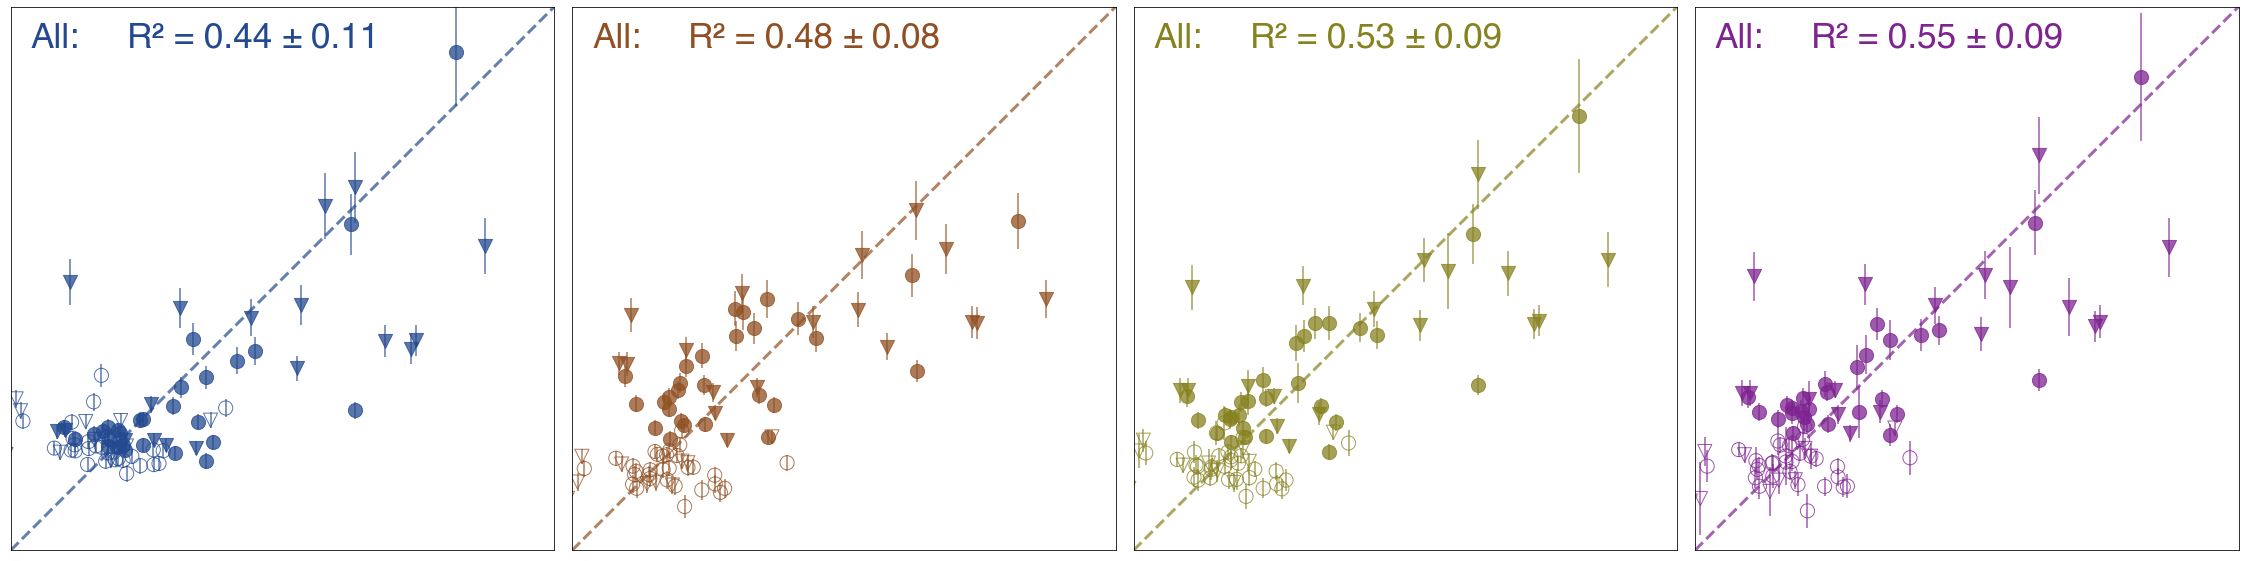

In [62]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(cortical_regions), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v','o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.05,0.25])
    plt.ylim([-0.05,0.25])
    plt.plot([-0.05,0.25],[-0.05,0.25],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD', 'MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.039,0.2275, 'All:', fontdict=fontdict)
    plt.text(0.014,0.2275, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2-cortical_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### Mean over Braak-V regions

In [33]:
braak_5_regions = DK[ (DK['Braak stage']==5.0) & (DK['Cortex']=='cortical')]['Other Name']

plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)

    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(braak_5_regions), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.20])
            plt.ylim([-0.10,0.20])
            plt.plot([-0.10,0.20],[-0.10,0.20],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.49 ± 0.10
0.51 ± 0.08
0.57 ± 0.08
0.58 ± 0.08
AD both
0.53 ± 0.10
0.56 ± 0.09
0.62 ± 0.09
0.64 ± 0.09
MCI both
0.41 ± 0.21
0.40 ± 0.14
0.48 ± 0.17
0.51 ± 0.17
both positive
0.56 ± 0.09
0.48 ± 0.09
0.59 ± 0.09
0.62 ± 0.09
both negative
0.16 ± 0.14
0.04 ± 0.05
0.19 ± 0.13
0.21 ± 0.13


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.49 $R^2$ = 0.10
$R^2$ = 0.51 $R^2$ = 0.08
$R^2$ = 0.57 $R^2$ = 0.08
$R^2$ = 0.58 $R^2$ = 0.08


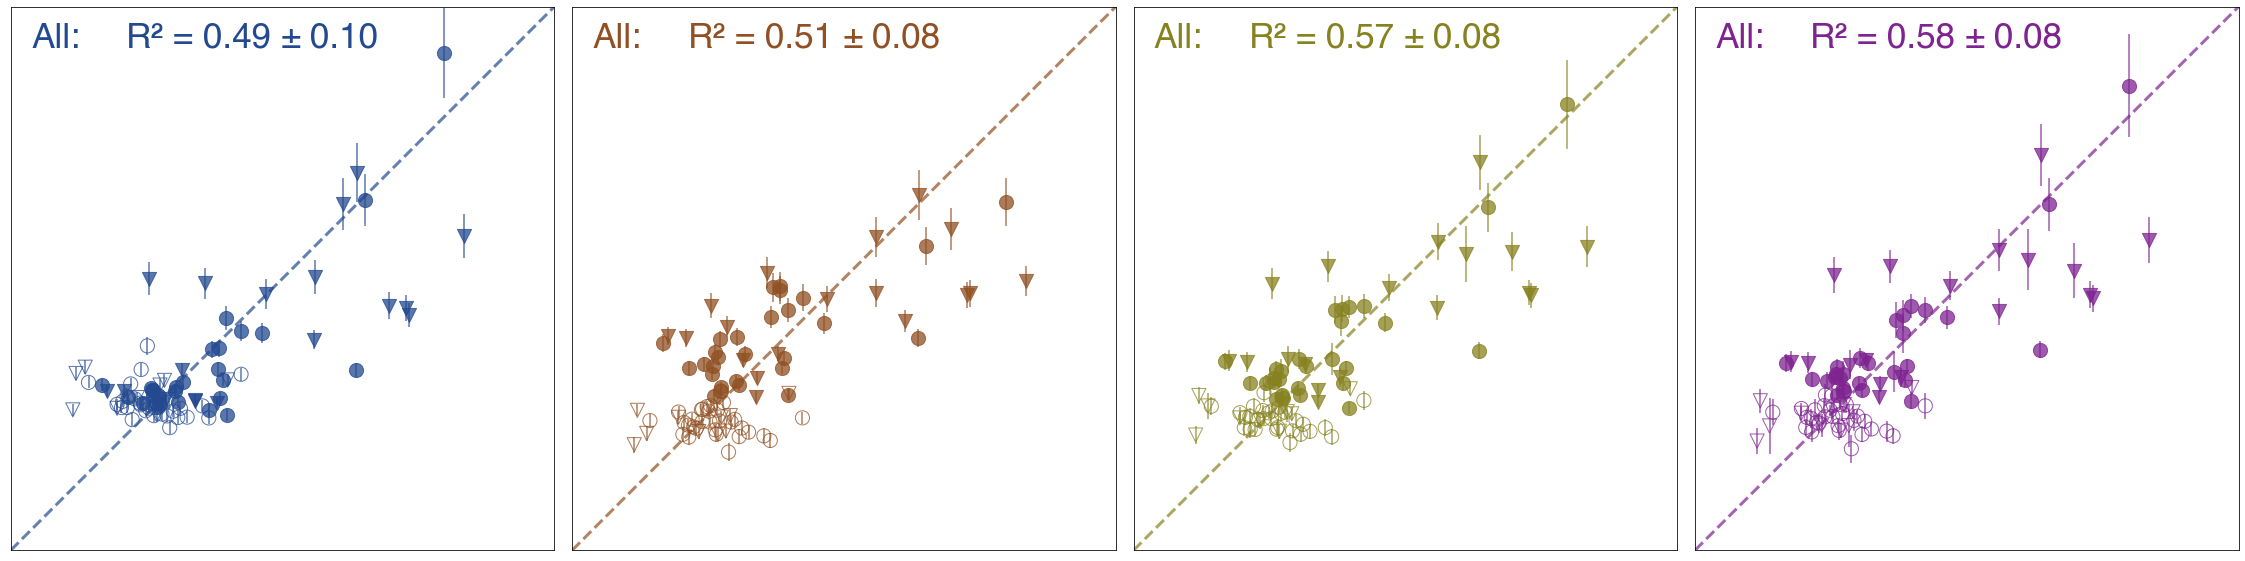

In [61]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(braak_5_regions), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v','o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD', 'MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'All:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2-braak5_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

## Mean over NDM-selected regions

### NDM regions 1-8

In [31]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)

    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(NDM_predicted_regions[:8]), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.3])
            plt.ylim([-0.10,0.3])
            plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.48 ± 0.11
0.47 ± 0.08
0.54 ± 0.09
0.57 ± 0.09
AD both
0.51 ± 0.13
0.52 ± 0.11
0.60 ± 0.11
0.62 ± 0.12
MCI both
0.40 ± 0.21
0.38 ± 0.13
0.47 ± 0.17
0.51 ± 0.17
both positive
0.55 ± 0.11
0.42 ± 0.10
0.57 ± 0.11
0.57 ± 0.11
both negative
0.12 ± 0.13
0.04 ± 0.05
0.17 ± 0.13
0.22 ± 0.14


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.51 $R^2$ = 0.13
$R^2$ = 0.52 $R^2$ = 0.11
$R^2$ = 0.60 $R^2$ = 0.11
$R^2$ = 0.62 $R^2$ = 0.12


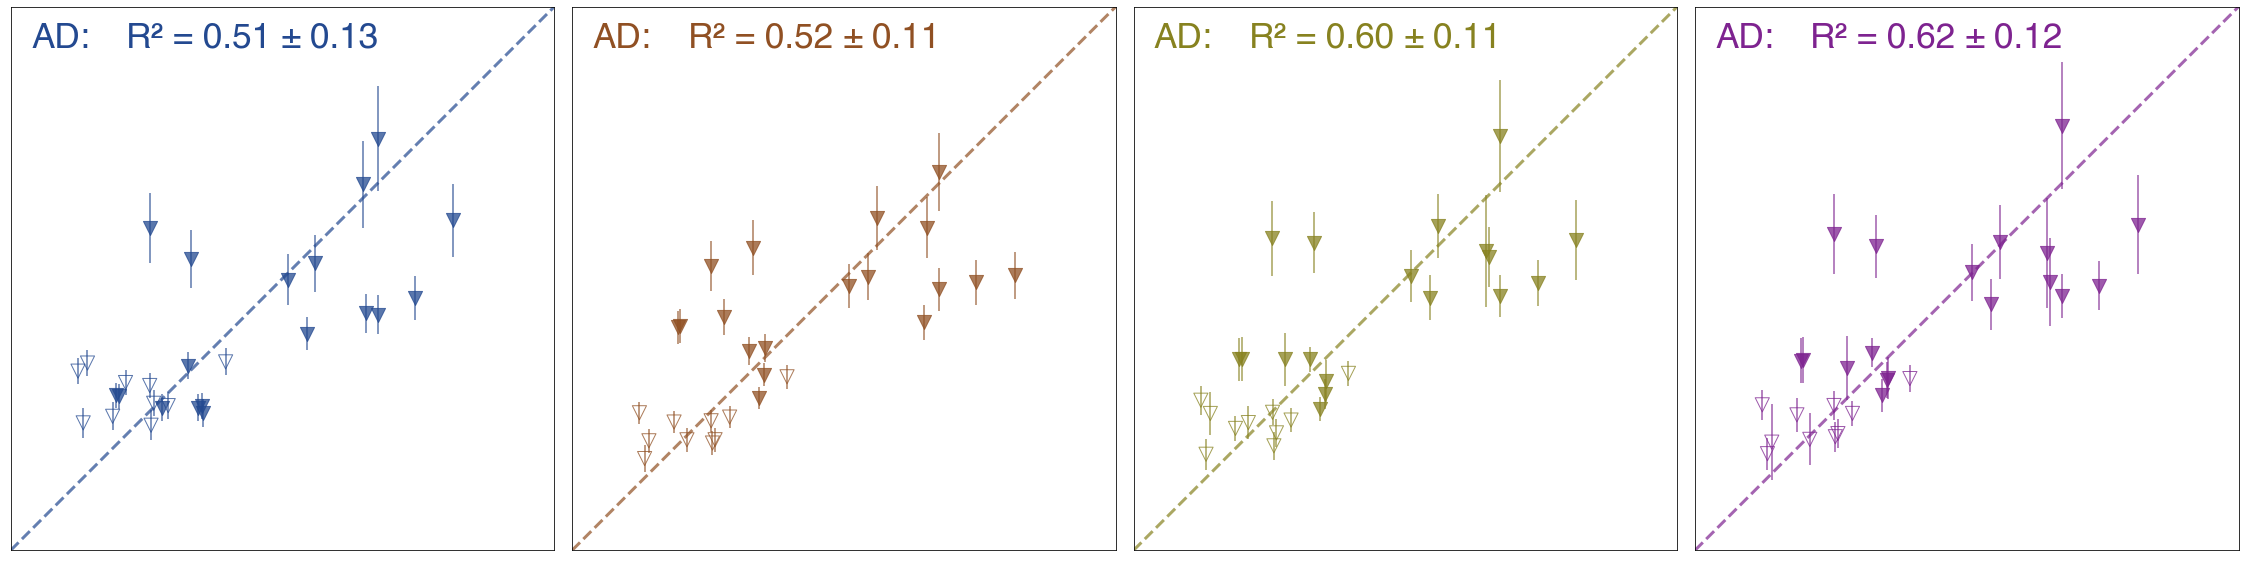

In [55]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-1-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.40 $R^2$ = 0.21
$R^2$ = 0.38 $R^2$ = 0.13
$R^2$ = 0.47 $R^2$ = 0.17
$R^2$ = 0.51 $R^2$ = 0.17


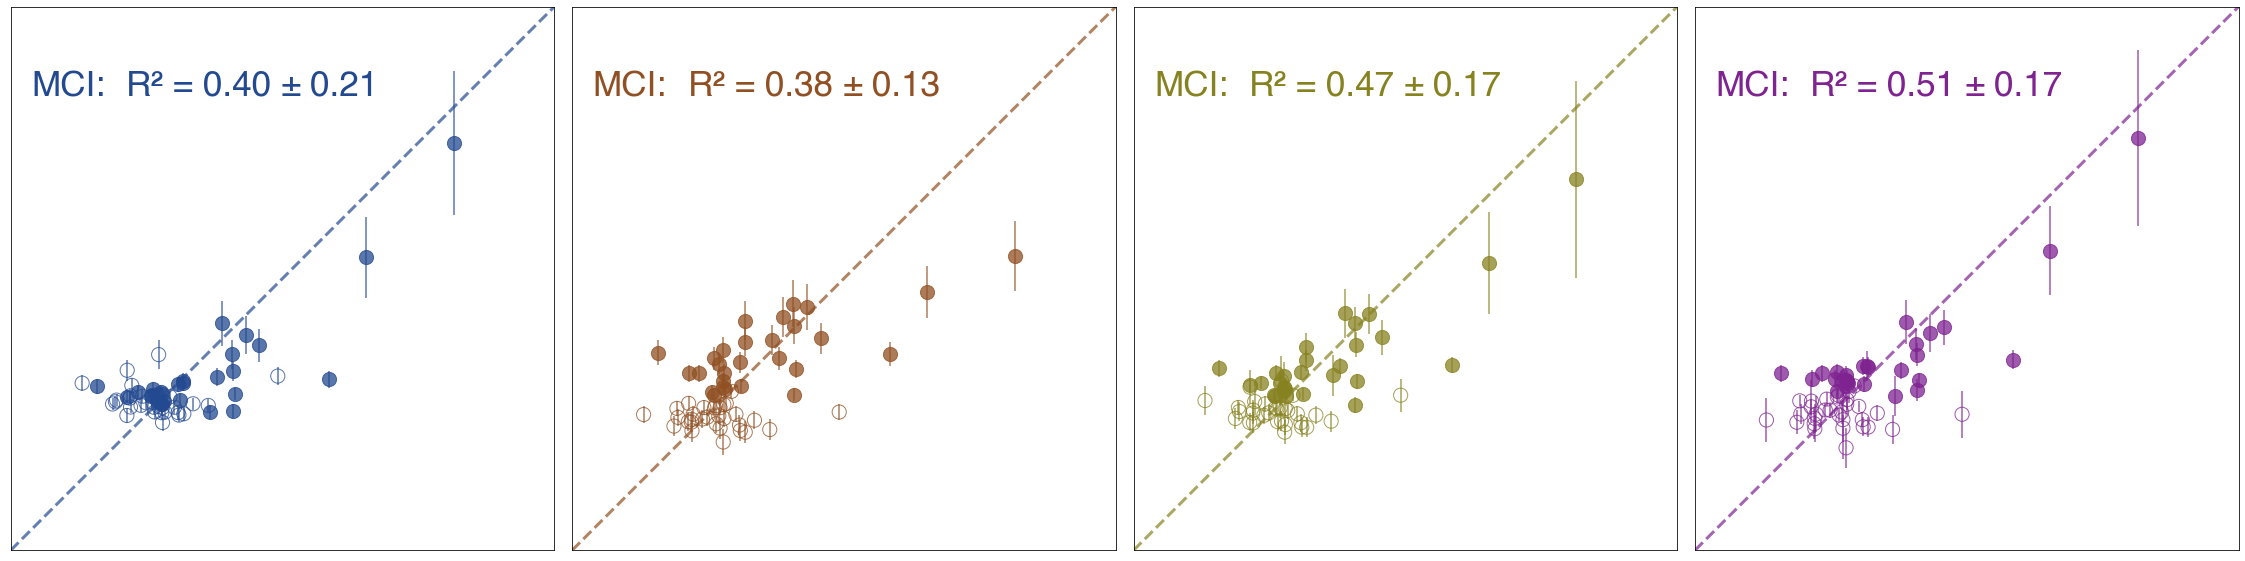

In [58]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-1-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### NDM regions 1-4

In [30]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)

    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(NDM_predicted_regions[:4]), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.3])
            plt.ylim([-0.10,0.3])
            plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.29 ± 0.10
0.33 ± 0.10
0.36 ± 0.10
0.43 ± 0.11
AD both
0.45 ± 0.16
0.53 ± 0.13
0.58 ± 0.15
0.70 ± 0.12
MCI both
0.19 ± 0.13
0.20 ± 0.12
0.24 ± 0.12
0.27 ± 0.13
both positive
0.43 ± 0.11
0.38 ± 0.10
0.45 ± 0.11
0.52 ± 0.11
both negative
0.11 ± 0.14
0.04 ± 0.06
0.16 ± 0.15
0.19 ± 0.17


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.45 $R^2$ = 0.16
$R^2$ = 0.53 $R^2$ = 0.13
$R^2$ = 0.58 $R^2$ = 0.15
$R^2$ = 0.70 $R^2$ = 0.12


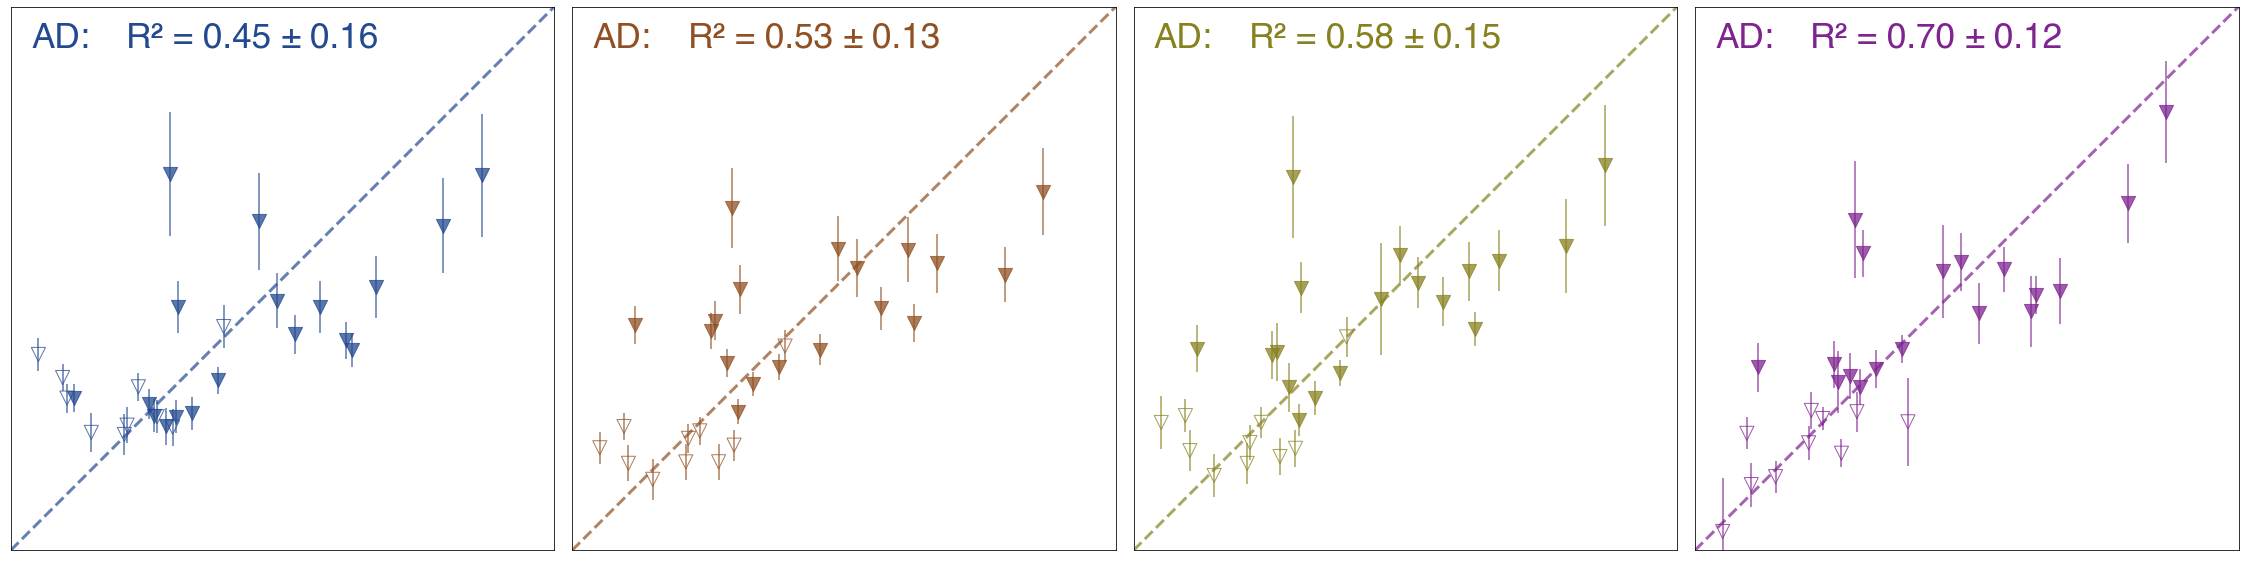

In [56]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-1-4_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.19 $R^2$ = 0.13
$R^2$ = 0.20 $R^2$ = 0.12
$R^2$ = 0.24 $R^2$ = 0.12
$R^2$ = 0.27 $R^2$ = 0.13


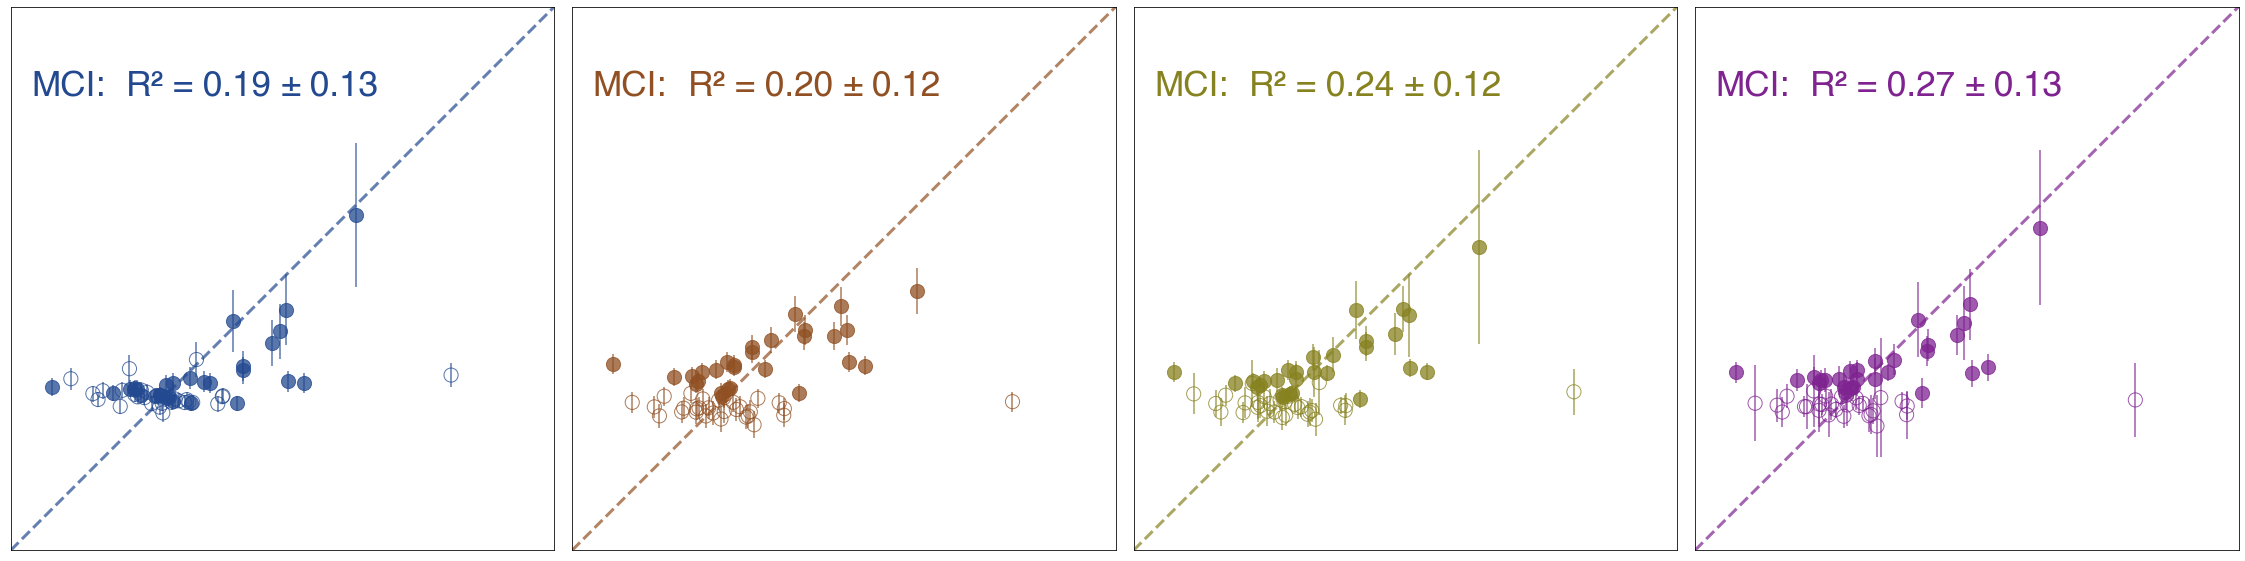

In [59]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-1-4_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### NDM regions 4-8

In [32]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)



    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(NDM_predicted_regions[4:8]), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.3])
            plt.ylim([-0.10,0.3])
            plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.54 ± 0.11
0.49 ± 0.07
0.59 ± 0.09
0.60 ± 0.09
AD both
0.46 ± 0.13
0.42 ± 0.10
0.51 ± 0.11
0.54 ± 0.12
MCI both
0.52 ± 0.24
0.48 ± 0.13
0.60 ± 0.17
0.65 ± 0.17
both positive
0.56 ± 0.12
0.38 ± 0.10
0.57 ± 0.12
0.59 ± 0.12
both negative
0.12 ± 0.09
0.03 ± 0.04
0.17 ± 0.08
0.23 ± 0.12


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.46 $R^2$ = 0.13
$R^2$ = 0.42 $R^2$ = 0.10
$R^2$ = 0.51 $R^2$ = 0.11
$R^2$ = 0.54 $R^2$ = 0.12


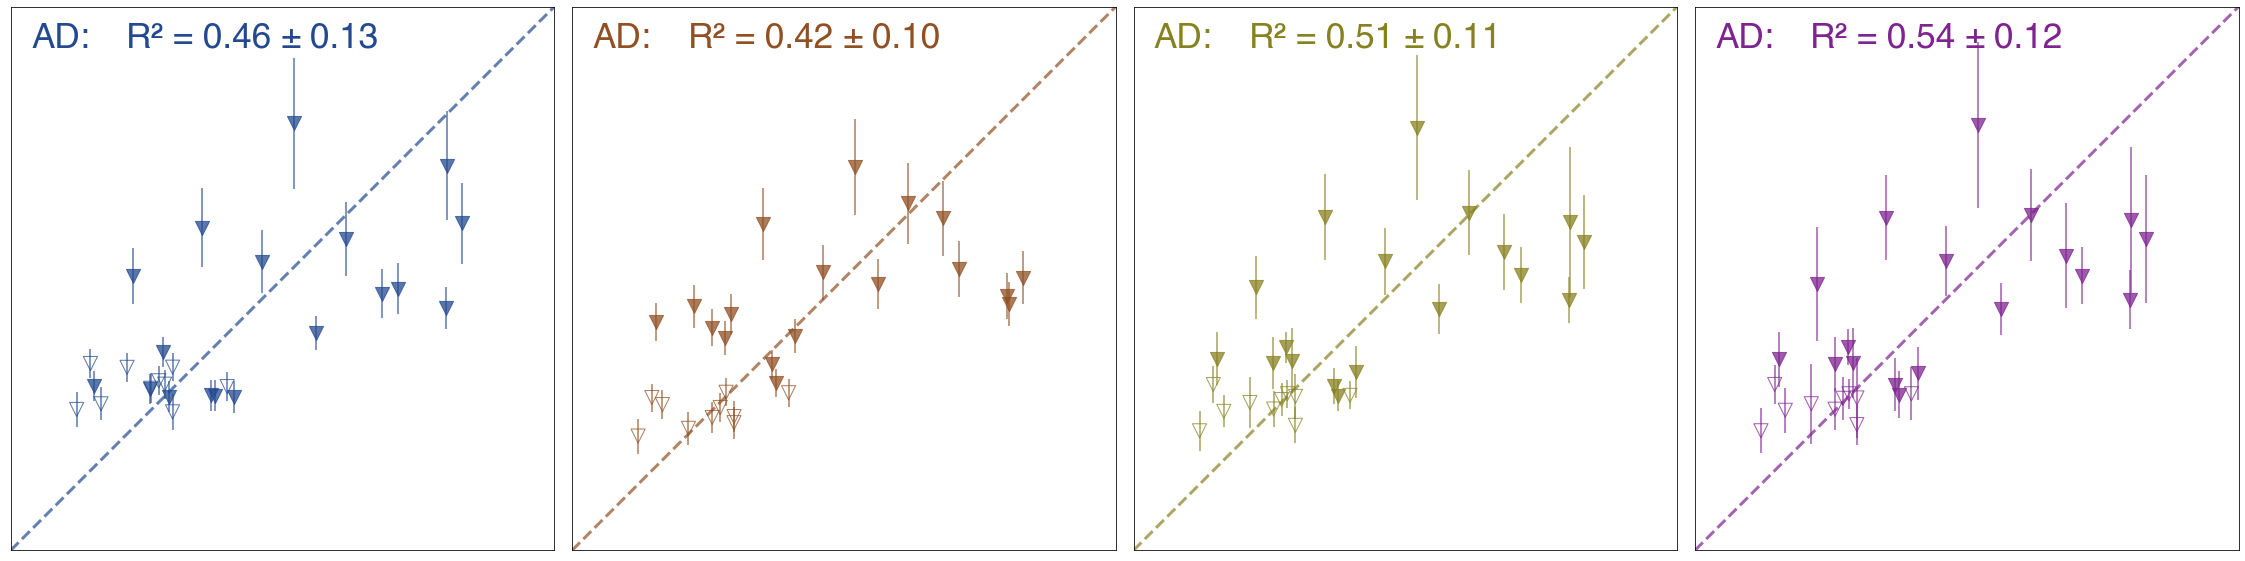

In [57]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[4:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-4-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.52 $R^2$ = 0.24
$R^2$ = 0.48 $R^2$ = 0.13
$R^2$ = 0.60 $R^2$ = 0.17
$R^2$ = 0.65 $R^2$ = 0.17


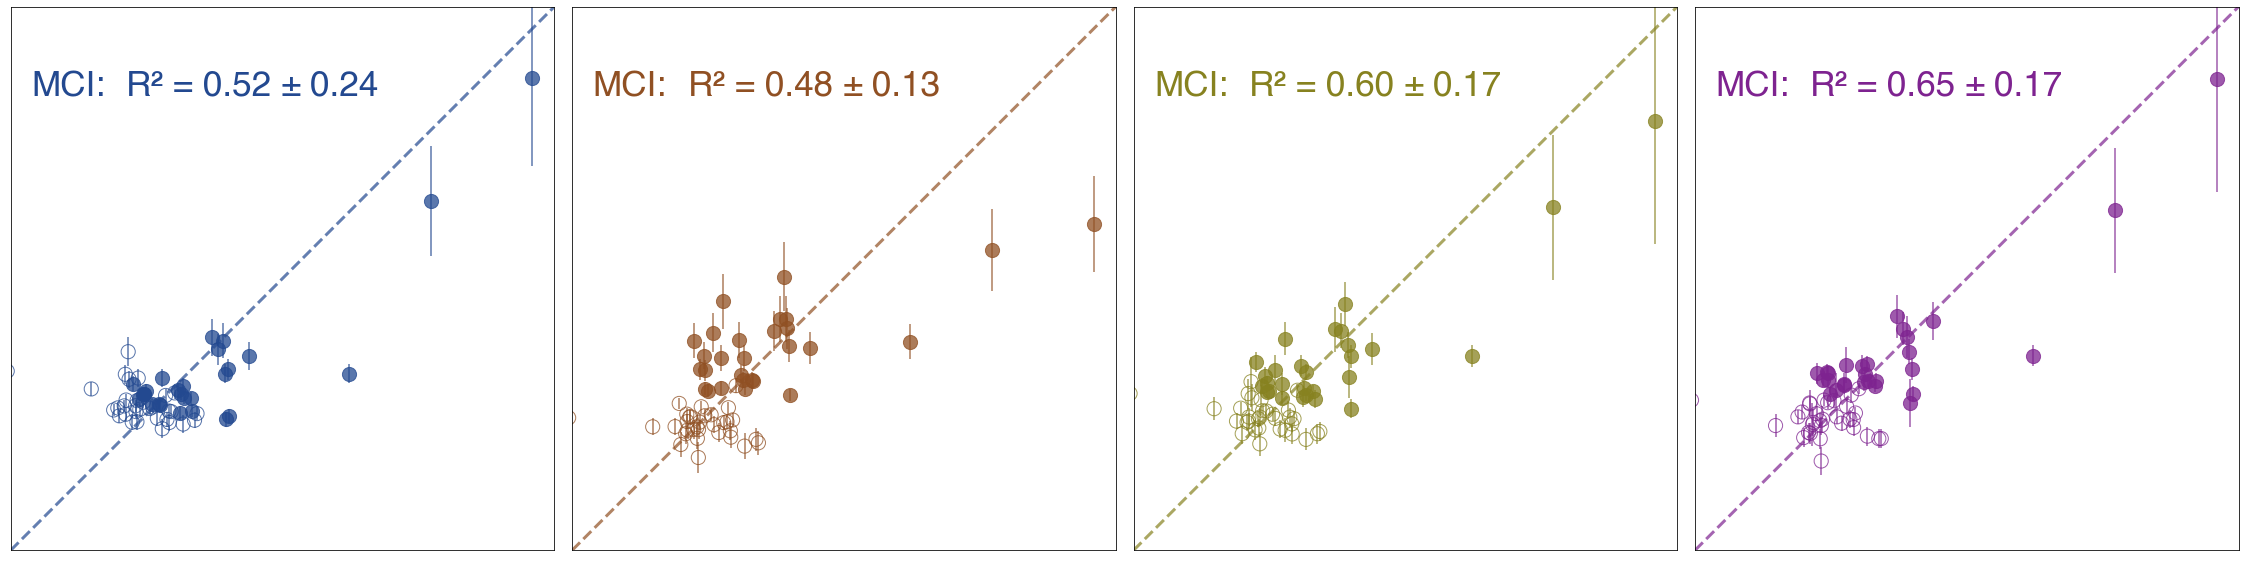

In [60]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[4:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M2_regions-4-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
markers = ['v','v','o','o']
colors = ['#234990','#905023','#878220','#7e2390']
facecolors = [colors[m], 'none', colors[m], 'none']

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([-2,4])
for i in range(4):
    plt.scatter(0,i, marker=markers[i], facecolors=facecolors[i], color=colors[m], s=5000, alpha=1.0, linewidths=10)
plt.savefig('../results/notebook_figs/M2_legend.png', dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)